In [16]:
import torch
torch.manual_seed(42)

In [2]:
import kagglehub
path=kagglehub.dataset_download("zalando-research/fashionmnist")

Using Colab cache for faster access to the 'fashionmnist' dataset.


In [3]:
import os
os.listdir(path)

['t10k-labels-idx1-ubyte',
 't10k-images-idx3-ubyte',
 'fashion-mnist_test.csv',
 'fashion-mnist_train.csv',
 'train-labels-idx1-ubyte',
 'train-images-idx3-ubyte']

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [8]:
df=pd.read_csv(path+'/fashion-mnist_train.csv')

In [58]:
data=df.iloc[0:6000,:]

In [59]:
data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5996,1,0,0,0,0,0,0,0,0,0,...,82,0,0,0,0,0,0,0,0,0
5997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5998,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
X=data.drop("label",axis=1)
y=data["label"]

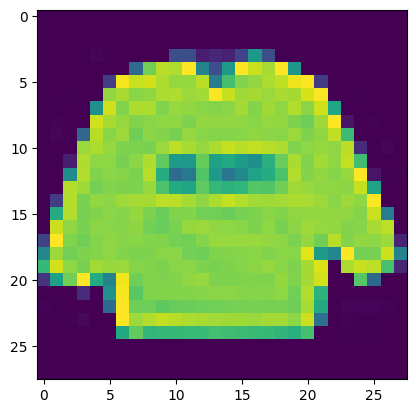

In [61]:
plt.imshow(X.loc[0].values.reshape(28,28))

In [62]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15)

In [63]:
x_train=(x_train.values)/255.0
x_test=(x_test.values)/255.0
y_train=y_train.values
y_test=y_test.values

In [64]:
from torch.utils.data import Dataset,DataLoader
class CustomDataset(Dataset):
    def __init__(self,features,label):
        self.features=torch.tensor(features,dtype=torch.float32)
        self.label=torch.tensor(label,dtype=torch.long)
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self,index):
        return self.features[index],self.label[index]

In [65]:
x_train_dataset=CustomDataset(x_train,y_train)
x_test_dataset=CustomDataset(x_test,y_test)

In [66]:
x_train_loader=DataLoader(x_train_dataset,batch_size=32,shuffle=True)
x_test_loader=DataLoader(x_test_dataset,batch_size=32,shuffle=True)

In [67]:
#define NN model class
import torch.nn as nn
class NnNetwork(nn.Module):
    def __init__(self,n_features):
        super().__init__()
        self.n_features=n_features
        self.network=nn.Sequential(
            nn.Linear(self.n_features,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )
    def forward(self,X):
        return self.network(X)


In [68]:
#lr and epochs
lr=0.1
epochs=100

In [69]:
model=NnNetwork(x_train.shape[1])
criterion=nn.CrossEntropyLoss()
from torch.optim import SGD
optimizer=SGD(model.parameters(),lr=lr)

In [ ]:
#training
for epoch in range(epochs):
    total_epoch_loss=0
    for x,y in x_train_loader:
        y_pred=model(x)
        loss=criterion(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_epoch_loss+=loss.item()
    avg_loss=total_epoch_loss/len(x_train_loader)
    print(f"average loss= {avg_loss}")

In [72]:
model.eval()

NnNetwork(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [73]:
total=0
correct=0
with torch.no_grad():
    for x_tes,y_tes in x_test_loader:
        outputs=model(x_tes)
        _,predicted=torch.max(outputs,1)
        total+=x_tes.shape[0]
        correct+=(predicted==y_tes).sum().item()
print(correct/total)

0.8244444444444444
